# RESEARCH ON MOVIES: BUDGET, GENDER DIVERSITY AND PUBLISHED ERA - WHAT DETERMINES A FILM’S GROSS PROFIT?

*Group Member: Huy Pham, Hao Jiang, Kerie Galvez, Steven Tsai*

## Project Proposal

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(cowplot)
library(dplyr)
library(GGally)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## 1. Background

Despite increasing attention to gender diversity in Hollywood, women have traditionally and continued to be underrepresented in movies (Kunsey, 2018). A popular method to gauge women’s involvement in movies is the Bechdel test. To pass the Bechdel test, a movie needs: 1) at least two women, 2) talking to each other and 3) the conversation topic is something other than a man (Selisker, 2015). 

The aforementioned issue inspired our topic: how would women’s involvement, among other factors, affect a movie’s success? To answer this, we perform the MLR model with the response variable being a movie’s gross income and the independent variables being the Bechdel test, budget, and published era.

## 2. Dataset Description

The dataset compiles 1615 movies released from 1990 to 2013. Each observation includes the following variables of interest:
- imdb: ID of the movie on IMDb
- binary: Whether a movie passes the Bechdel test
- budget: Budget spent on the movie
- domgross: Domestic (U.S. and Canada) income of the movie
- intgross: International income of the movie
- period code: If a movie is released from 2010-2013, the period code is 1; 2005-2009 is 2, 2000-2004 is 3, 1995-1999 is 4, and 1990-1994 is 5

## 3. Preliminary Results

### Cleaning and Wrangling of Data

In [2]:
download.file("https://github.com/fivethirtyeight/data/raw/master/bechdel/movies.csv", destfile = "movies.csv")
movie_data <- read.csv("movies.csv")
# head(movie_data)


In [3]:
clean_movie_data <- movie_data %>%
                    mutate(domgross = as.integer(domgross), #convert the data type into integer 
                           intgross = as.integer(intgross),
                           decadeCode = decade.code,
                           periodCode = period.code) %>%
                    filter(!is.na(year&budget&domgross&intgross&periodCode&decadeCode)) %>% #skip the null values
                    mutate(tot_gross = domgross + intgross) %>%
                    select(year,imdb,budget,binary,domgross,intgross,periodCode,decadeCode)
# head(clean_movie_data)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion to integer range”


### Associations Discovery

First, we explore the association between all variables using pair plot and heat map.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



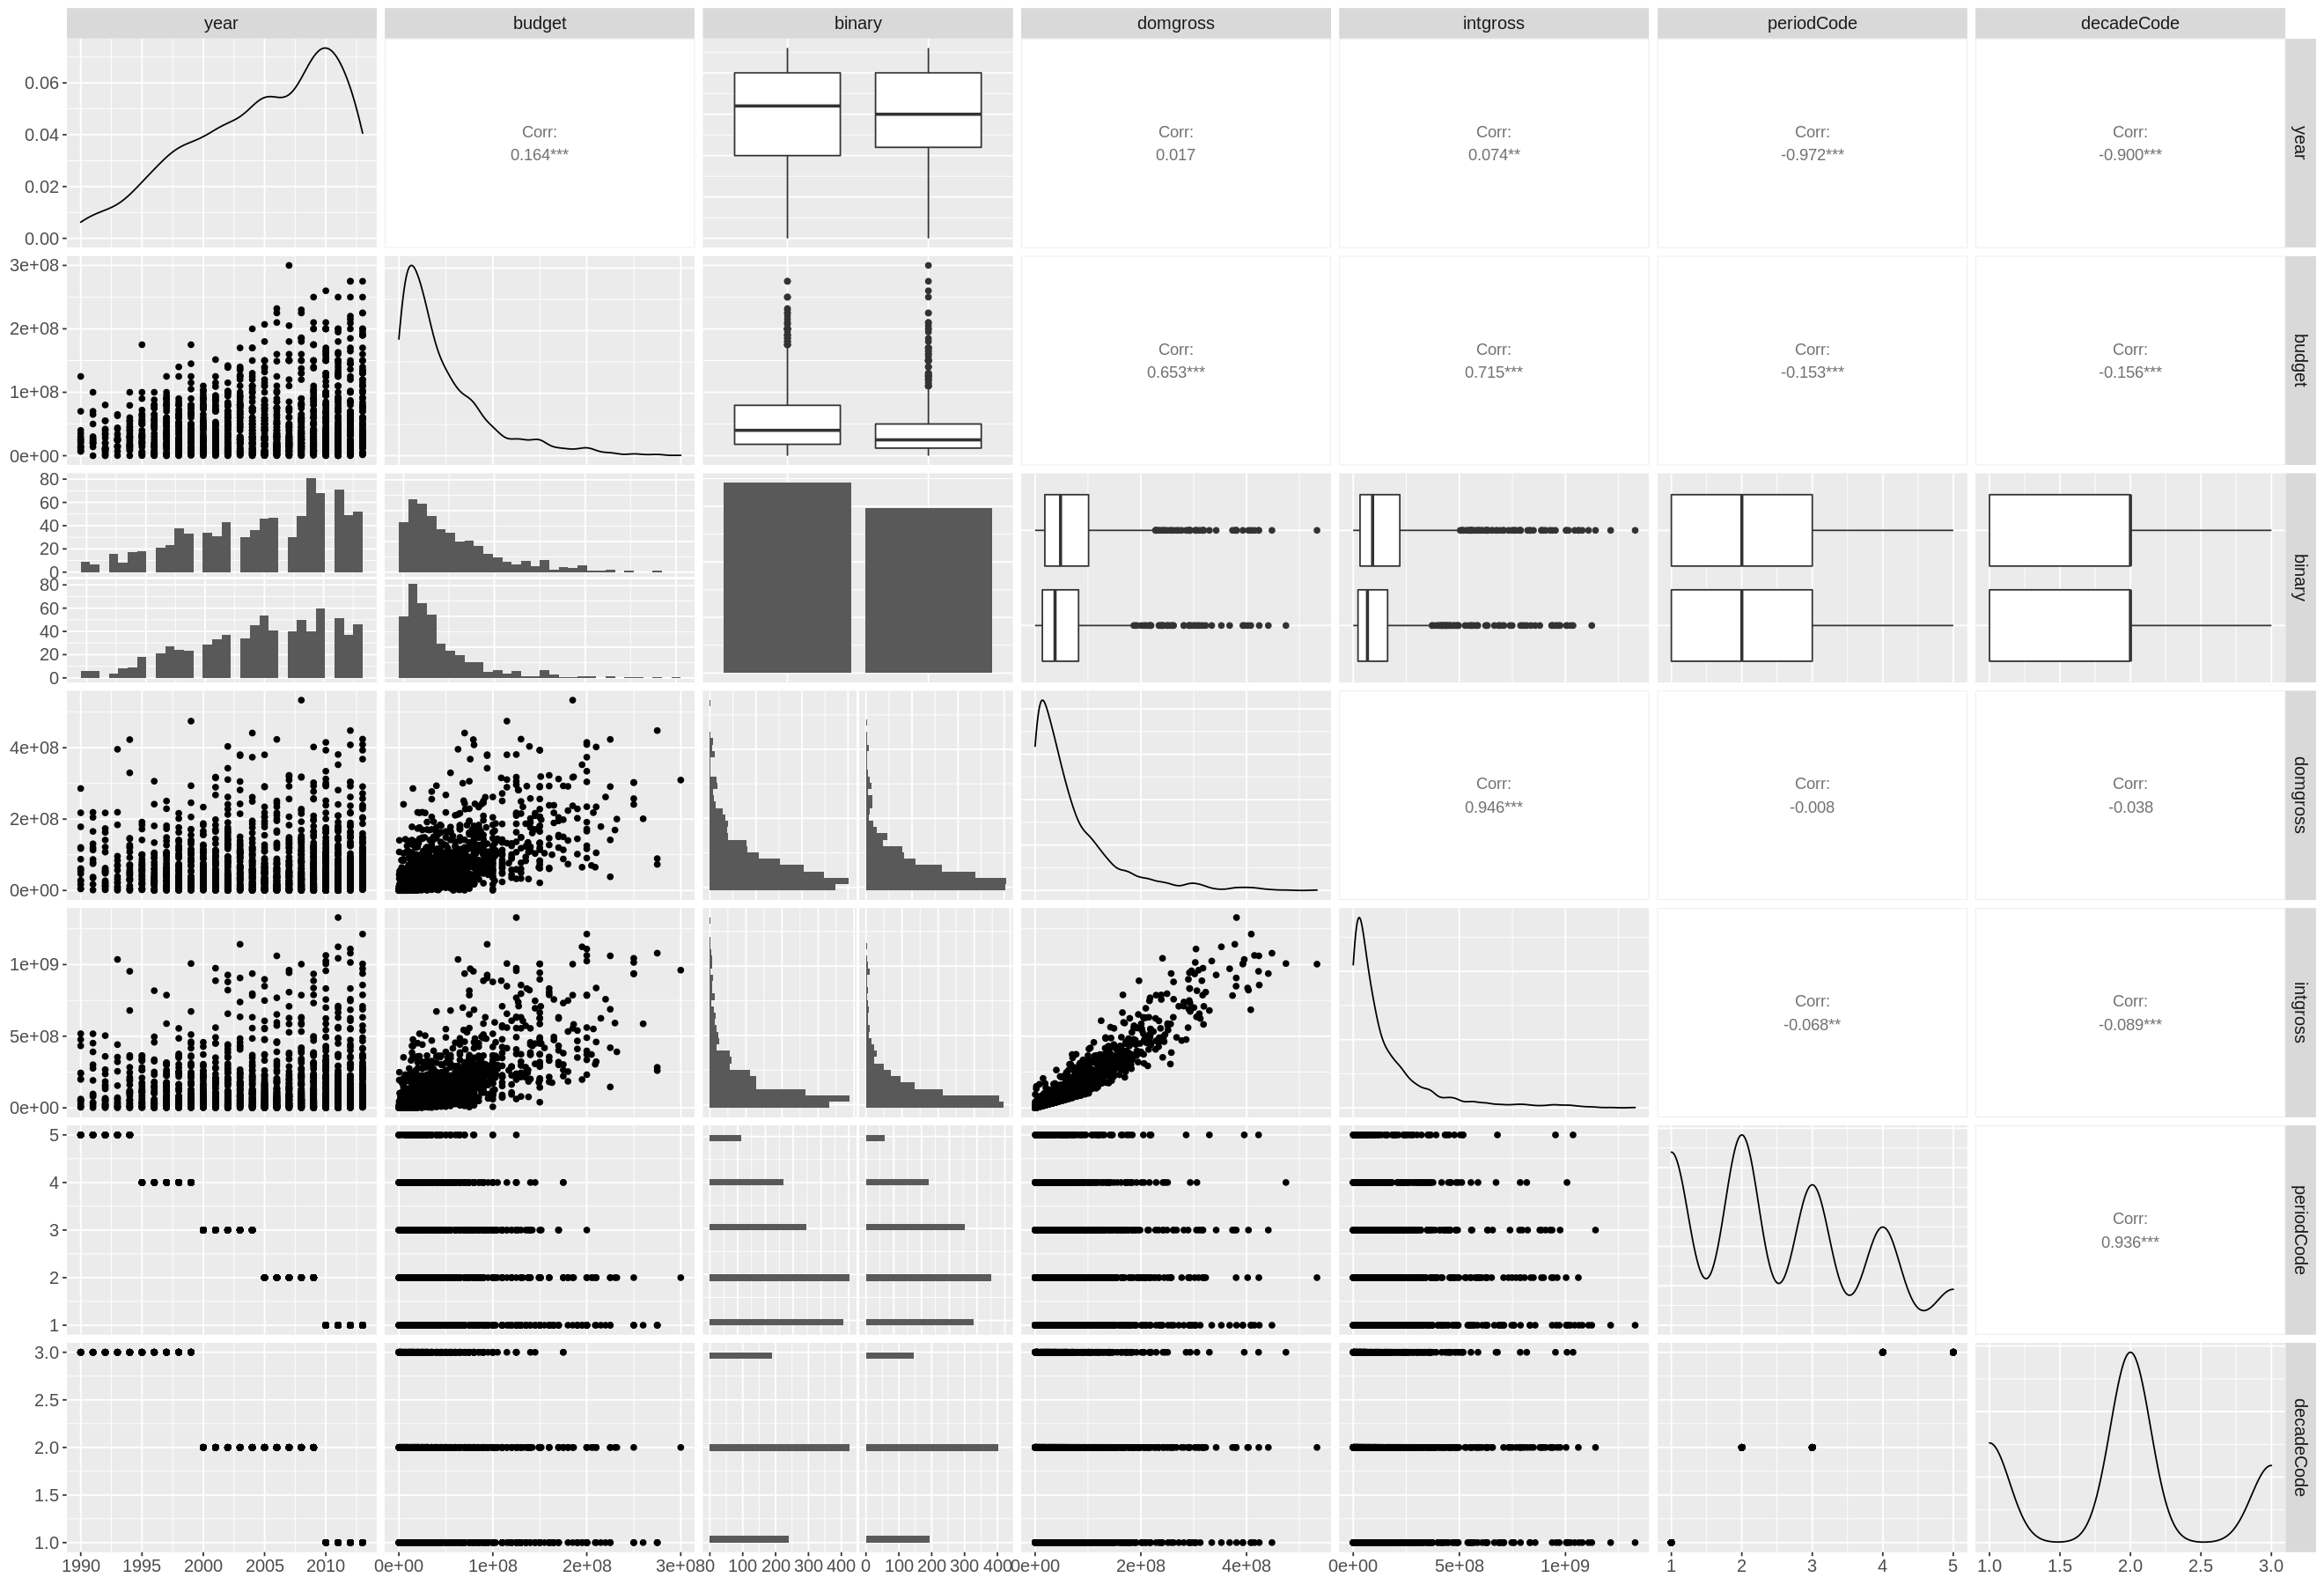

In [4]:
options(repr.plot.width = 22, repr.plot.height = 15)
#using ggpairs()
Movies_pair_plots <- clean_movie_data %>%
  select(- imdb) %>%
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
Movies_pair_plots

*Figure 1: Associations among variables*

> Figure 1 shows that international income moderately correlated to budget and highly correlated to domestic income, but weakly correlated to the remaining variables.

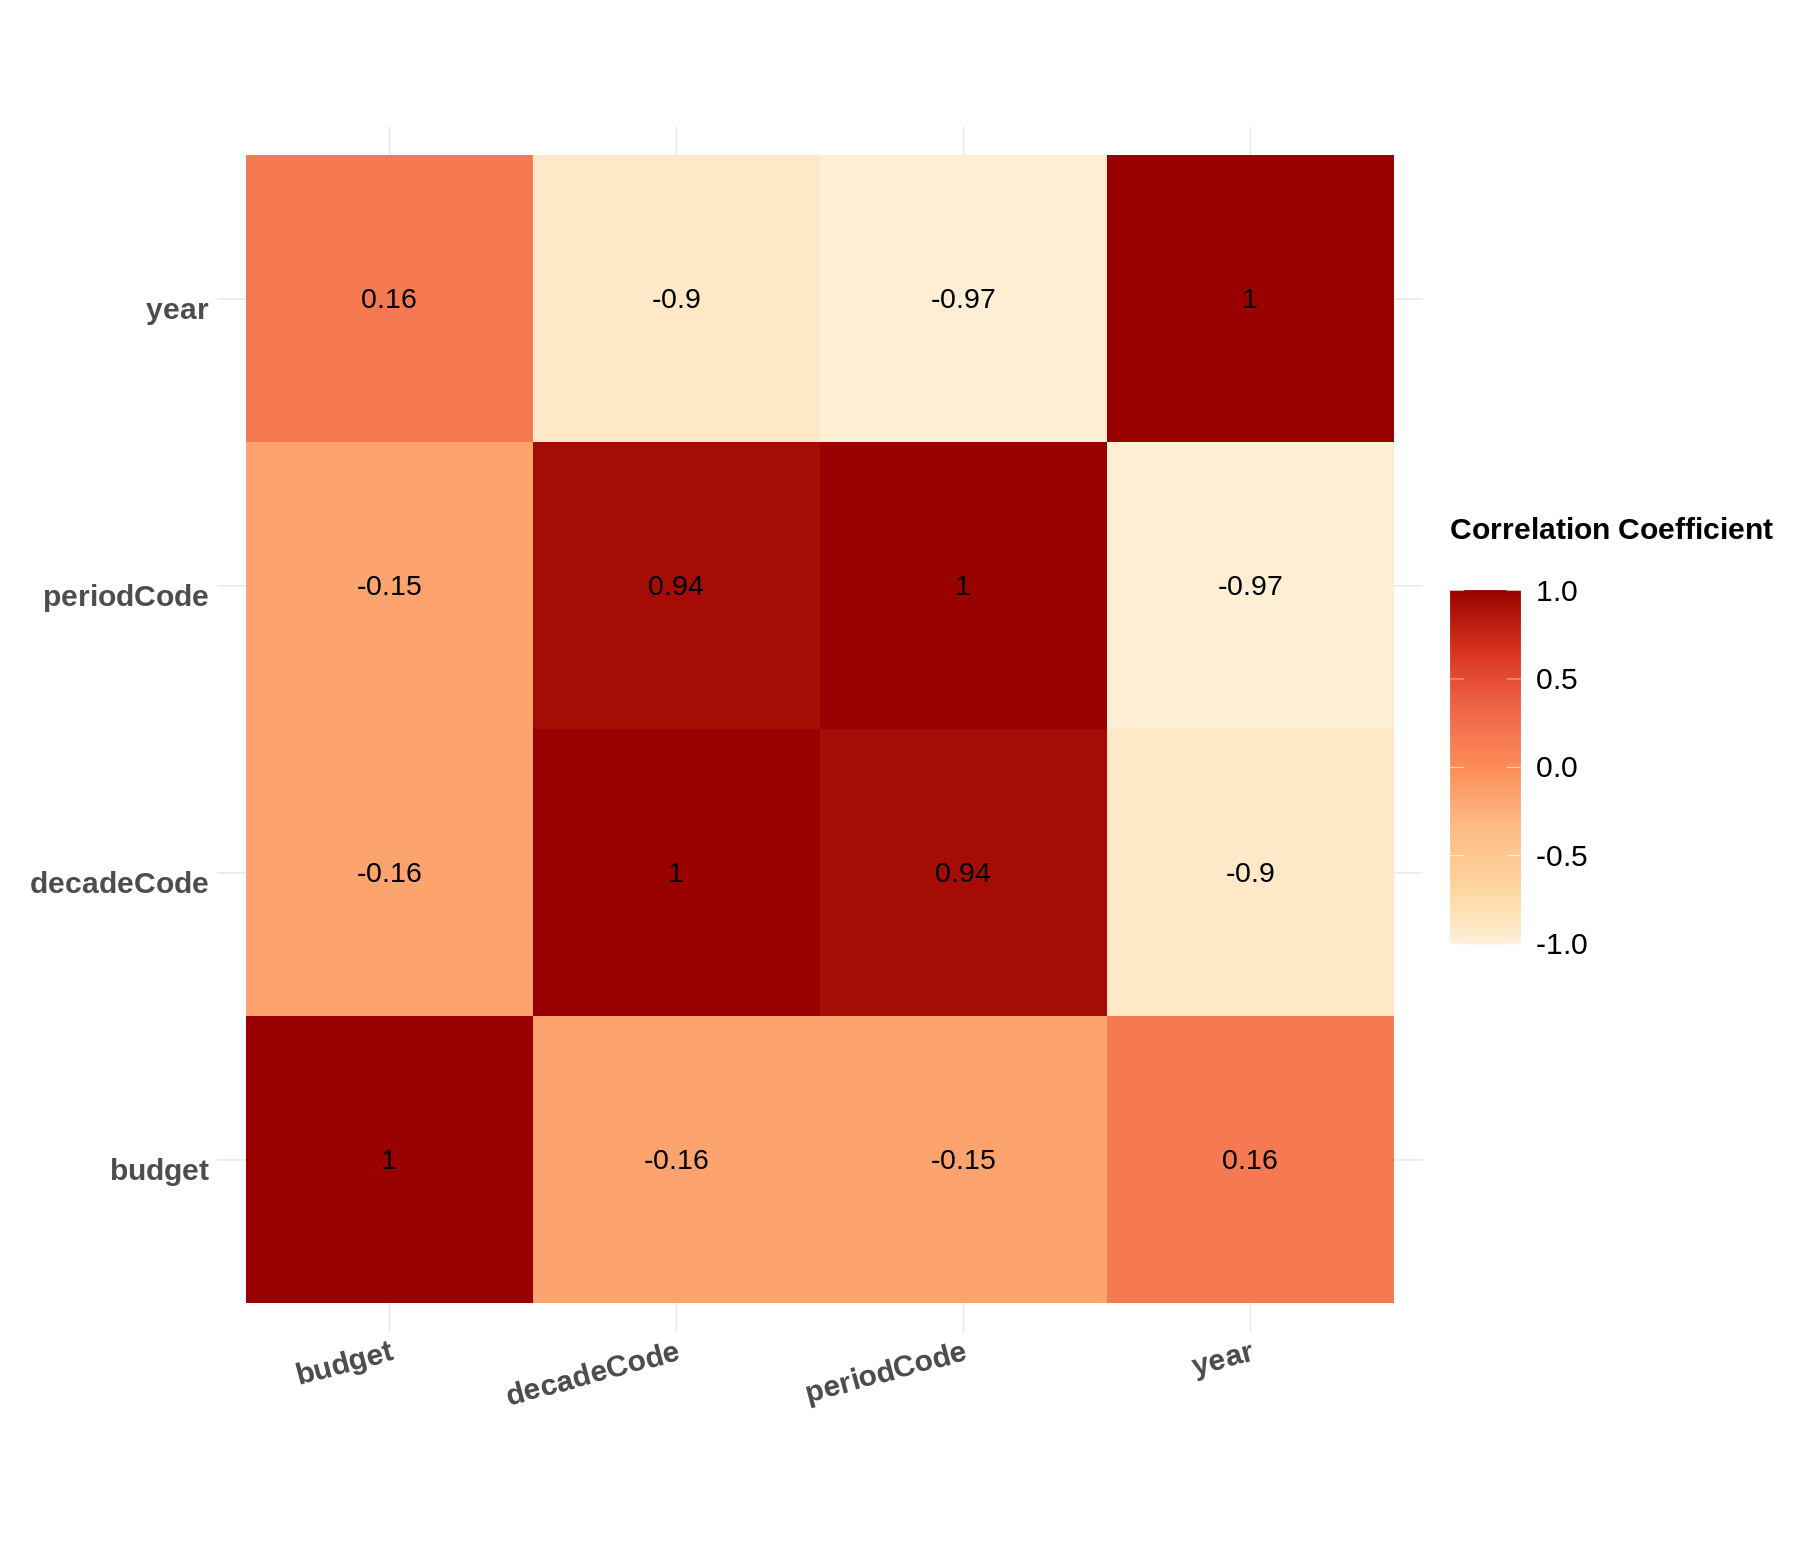

In [6]:
options(repr.plot.width = 15, repr.plot.height = 13)
corr_matrix_movies <- clean_movie_data %>%
  select(- c(imdb,domgross,binary,intgross)) %>% 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")


plot_corr_matrix_movies <- corr_matrix_movies %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr)) +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "OrRd",
    direction = 1, limits = c(-1,1)) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(
      angle = 15, vjust = 1,
      size = 18, hjust = 1,
      face = "bold"),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1,
      face = "bold"
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(1.5, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr,digits =2)), color = "black", size = 6)
plot_corr_matrix_movies

*Figure 2: Heatmap of the pairwise correlation coefficients*

> Other than within time-related variables (year, periodCode, decadeCode), the variables are weakly related to each other. In terms of the three time-related variables, we will only use periodCode to avoid multicollinearity.

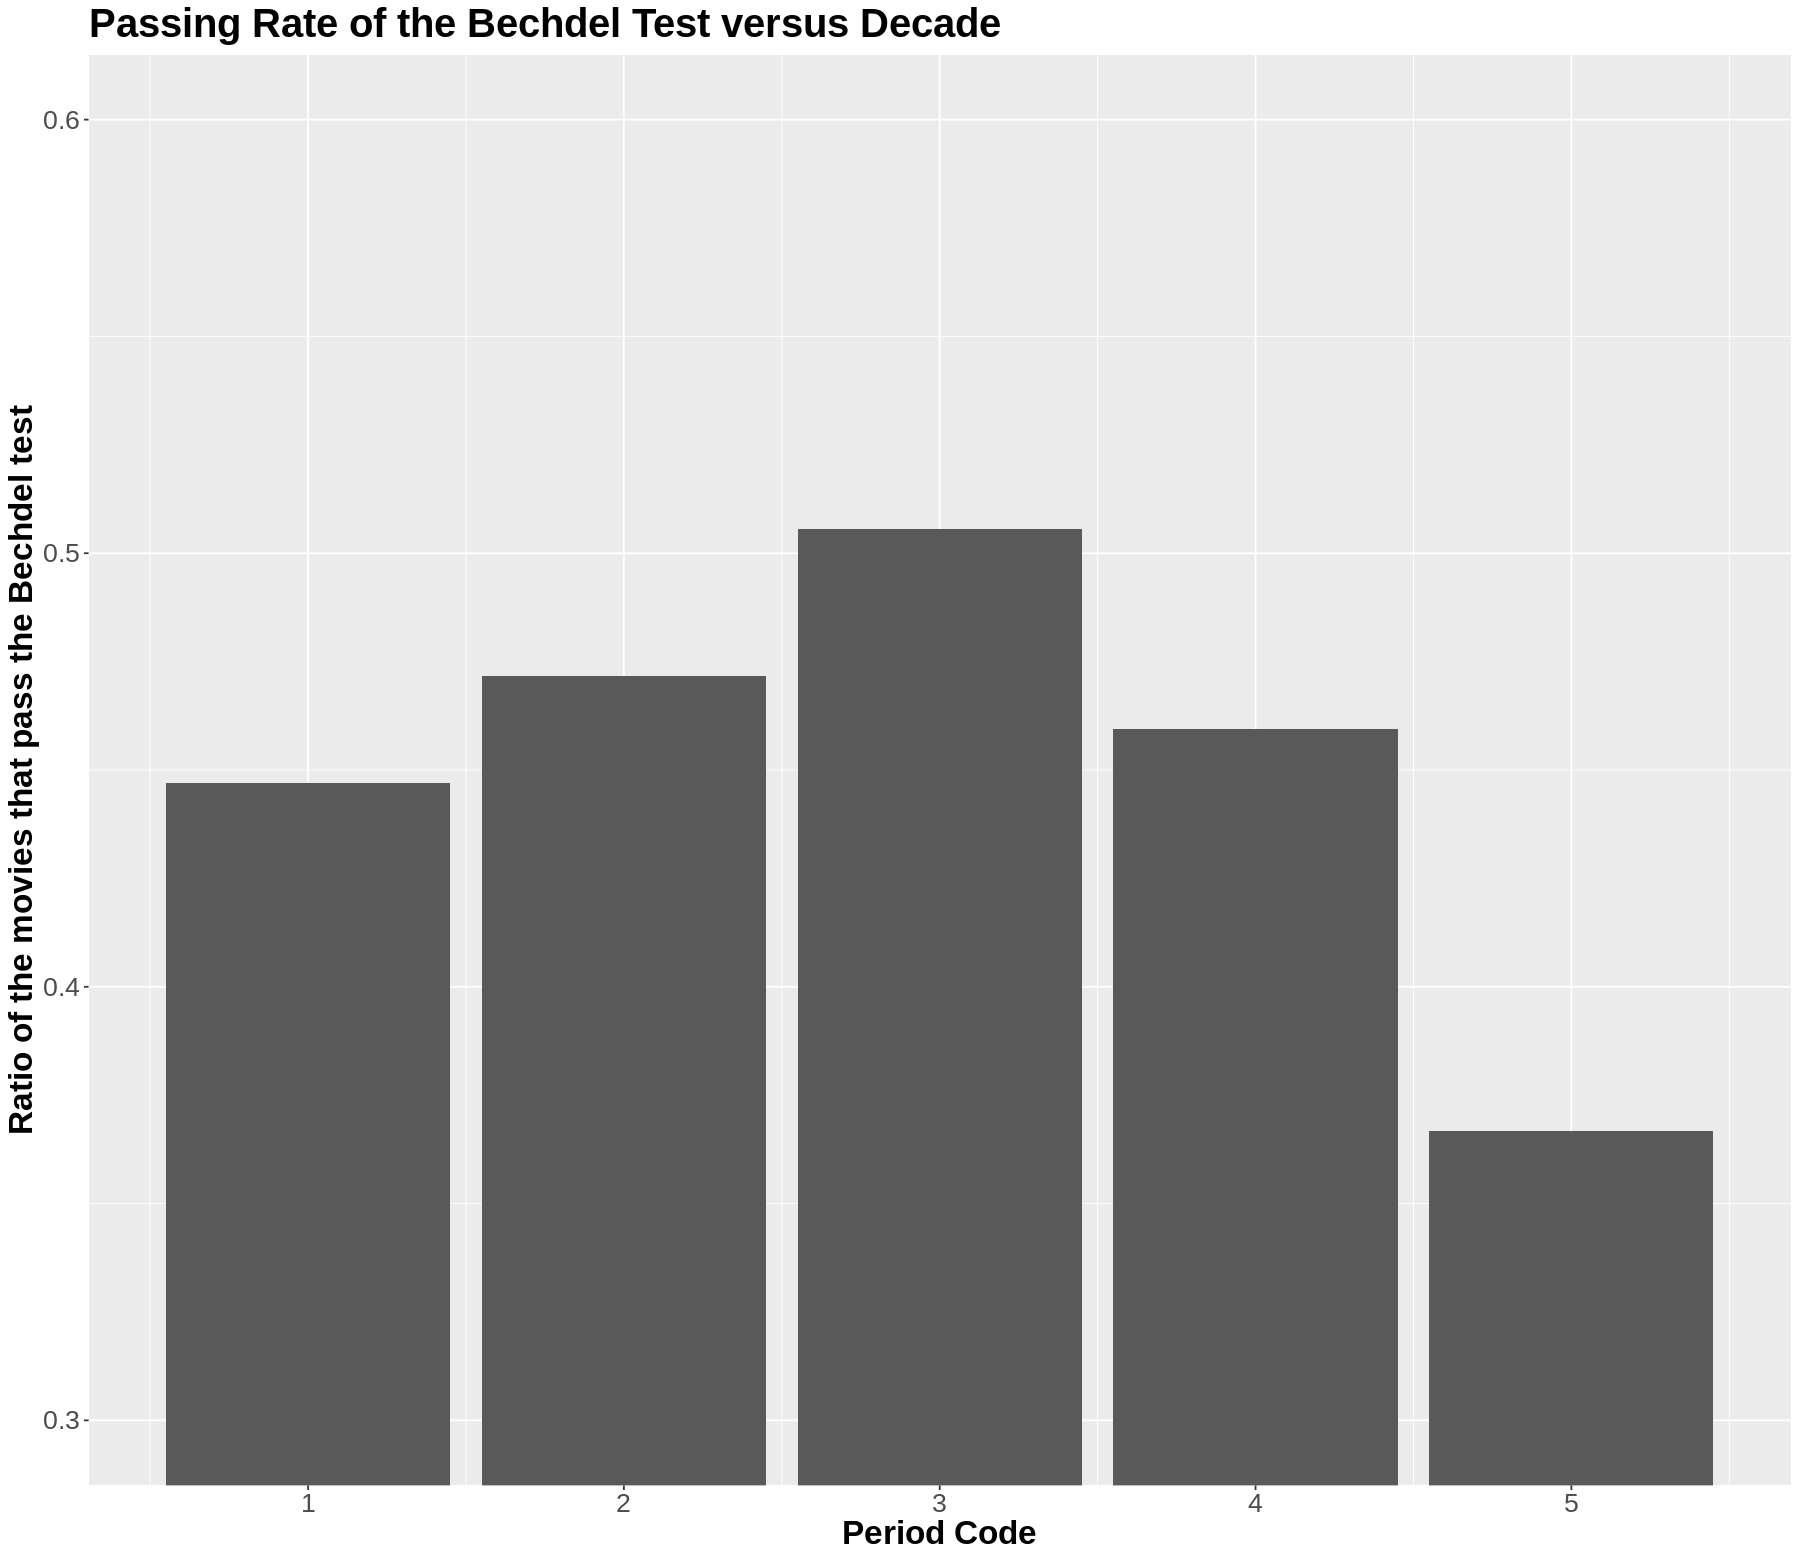

In [8]:
decaderatio <- clean_movie_data %>%
         group_by(periodCode) %>%
         summarise(success = mean(binary == "PASS"))

SLR_decade_testpass <- decaderatio %>%
              ggplot(aes(x = periodCode, y = success)) +
              geom_bar(stat="identity") +
              xlab("Period Code") +
              ylab("Ratio of the movies that pass the Bechdel test") +
              ggtitle("Passing Rate of the Bechdel Test versus Decade") +
              coord_cartesian(ylim = c(0.3,0.6)) +
              theme(
              text = element_text(size = 20),
              plot.title = element_text(face = "bold"),
              axis.title = element_text(face = "bold")
              )
SLR_decade_testpass

*Figure 3: the passing rate of the Bechdel Test over time (note that a smaller period code refers to more recent years)*

> Even though there is no apparent upward trend of the passing rate over time (i.e. from period code = 5 to period code = 1 since the greater the period code, the older the movies are), more recent movies still have a higher percentage of passing the Bechdel Test compared to the older ones.

### Selection of Input Variables

From above analyses, we incorporate three input variables into our MLR:
- budget (it correlates a lot with gross income)
- binary (we are interested in women's involvement effect)
- periodCode (the passing rate of the Bechdel test rate changes over time)

### Trending Discovery

We include a simple regression just to see any preliminary issue surface. 

`geom_smooth()` using formula 'y ~ x'



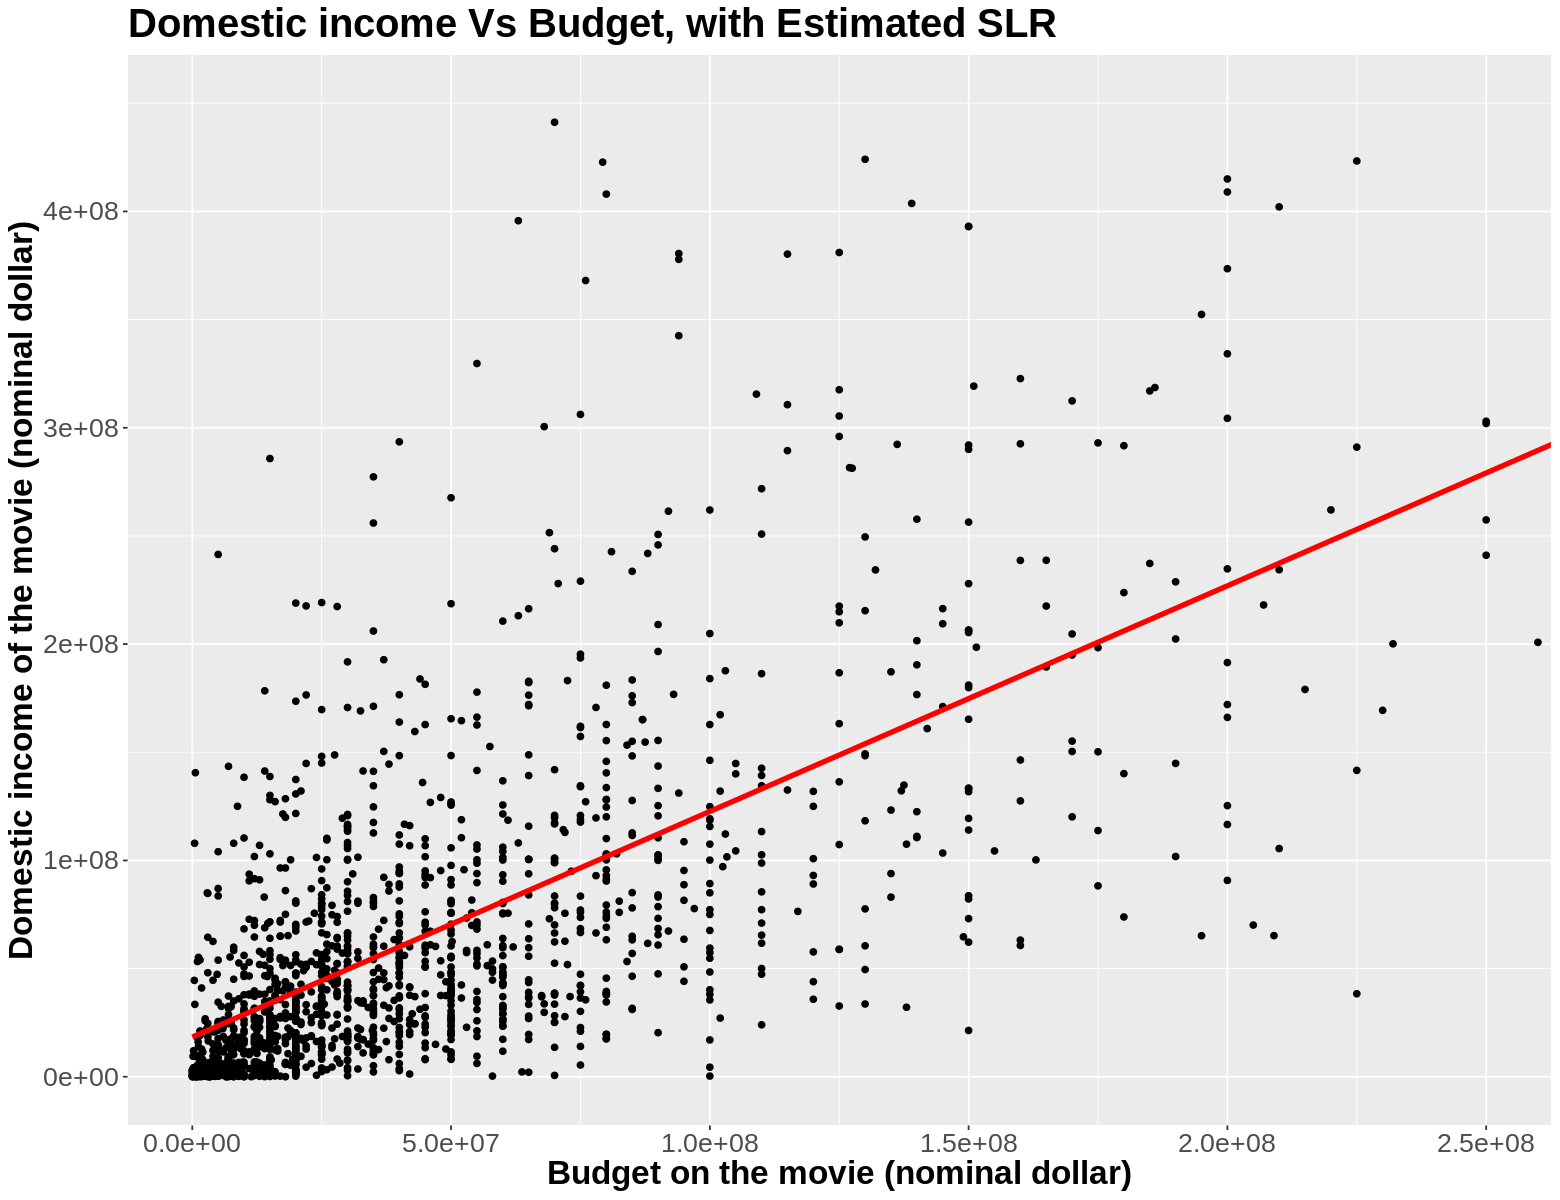

In [11]:
options(repr.plot.width = 13, repr.plot.height = 10)

SLR_budget_dom <- clean_movie_data %>%
              ggplot(aes(x = budget, y = domgross)) +
              geom_point() +
              geom_smooth(aes(x= budget, y = domgross), method = lm, se = FALSE, size = 1.5, colour = "red") +
              coord_cartesian(xlim = c(0, 2.5*10^8), ylim = c(0, 4.5*10^8)) +
              xlab("Budget on the movie (nominal dollar)") +
              ylab("Domestic income of the movie (nominal dollar)") +
              ggtitle("Domestic income Vs Budget, with Estimated SLR") +
              theme(
              text = element_text(size = 20),
              plot.title = element_text(face = "bold"),
              axis.title = element_text(face = "bold")
              )

SLR_budget_dom

*Figure 4: Domestic gross income versus Budget*

`geom_smooth()` using formula 'y ~ x'



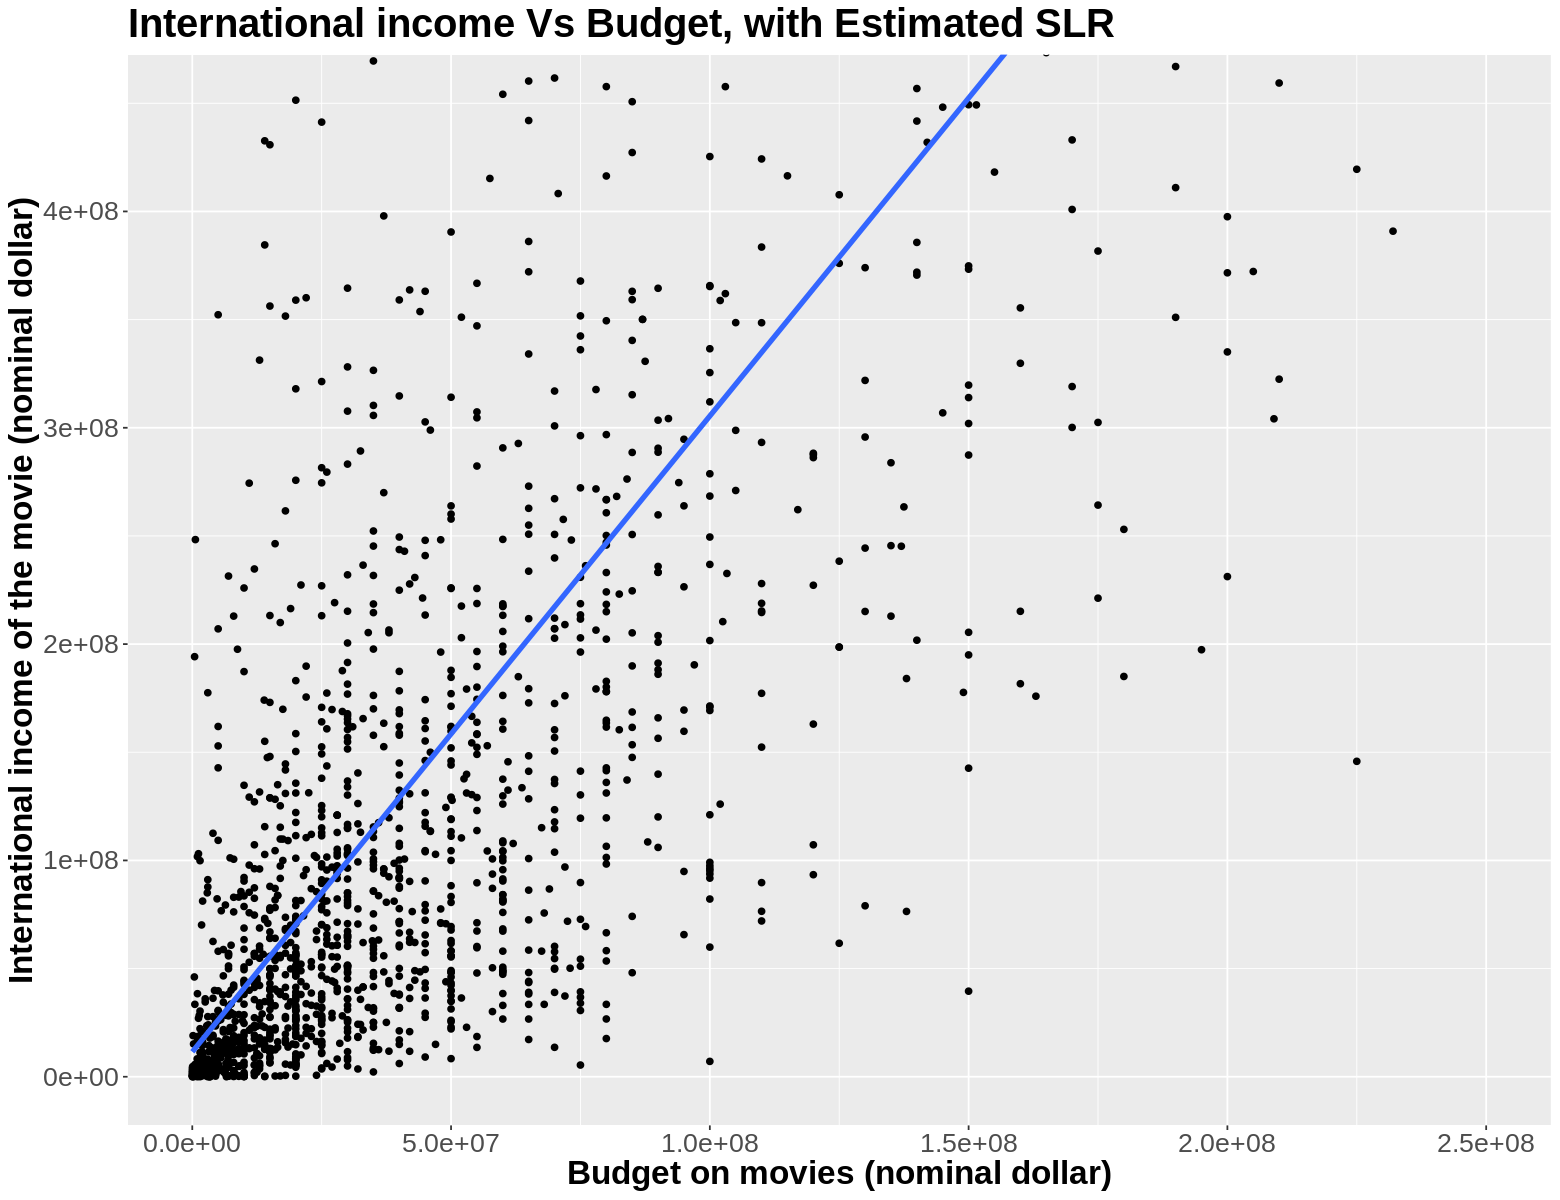

In [12]:
SLR_budget_int <- clean_movie_data %>%
              ggplot(aes(x = budget, y = intgross)) +
              geom_point() +
              geom_smooth(aes(x= budget, y = intgross), method = lm, se = FALSE, size = 1.5) +
              coord_cartesian(xlim = c(0, 2.5*10^8), ylim = c(0, 4.5*10^8)) +
              xlab("Budget on movies (nominal dollar)") +
              ylab("International income of the movie (nominal dollar)") +
              ggtitle("International income Vs Budget, with Estimated SLR") +
              theme(
              text = element_text(size = 20),
              plot.title = element_text(face = "bold"),
              axis.title = element_text(face = "bold")
              )

SLR_budget_int

*Figure 5: International gross income versus Budget*

> From figure 4 and 5, a positive relationship between budget and either domestic or international income is shown with the linear regression model, though heteroscedasticity seems to occur.

## 4. Methods: Plans 

Our dataset is an unbiased sample and large enough to draw estimates about the population. The relationship between budget and income can be reasonably assumed as a linear relationship and MLR would be an effective method. Lastly, we also address any violated assumption in the regression model e.g heteroscedasticity.

### 4.1 Methods Planned to be Used

We first determine if our dataset follows the assumptions of linear regression models. Afterwards, we will fit two MLR models with interaction across our dataset, each model taking either the domestic or international gross income as the response variable. We then conduct hypothesis tests using F-tests to determine if our MLR models are statistically different from an intercept-only model and test it at a significance level α = 0.05.

### 4.2 Expectation of Achievement

We expect to find a statistical association between a movie’s income with its budget and women’s involvement. This relationship is expected to be consistent in both MLR models. 

### 4.3 Potential Impact of the Results

Our report can help movie producers better understand what contributes to a movie’s success, especially regarding women’s involvement. Given the profit-driven nature of the movie industry, this would incentivize women representation in movies.

## 5. References 

Kunsey, I. (2019). Representations of Women in Popular Film: A Study of Gender Inequality in 2018. \
Selisker, Scott. (2015). The Bechdel Test and the Social Form of Character Networks. New Literary History. 46. 505-523. 10.1353/nlh.2015.0024. 
